## Задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [42]:
# imports
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [2]:
df = pd.read_csv("HW_data.csv")
# convert ['channel', 'zip_code'] to dummy
one_hot_channel = pd.get_dummies(df['channel'])
one_hot_zip = pd.get_dummies(df['zip_code'])
df = df.join(one_hot_channel)
df = df.join(one_hot_zip)
df = df.drop(['channel', 'zip_code'], axis=1)

# rename columns
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

# coding treatment
df['treatment'] = df['treatment'].apply(lambda i : 0 if i == 'No Offer' else 1)
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,Multichannel,Phone,Web,Rural,Surburban,Urban
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,0,1,1,0,0
2,7,180.65,0,1,1,1,0,0,0,1,0,1,0
3,9,675.83,1,0,1,1,0,0,0,1,1,0,0
4,2,45.34,1,0,0,1,0,0,0,1,0,0,1


In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), df['target'],
                                                    test_size=0.33, random_state=42)
treat_train = X_train.loc[:, 'treatment']
treat_test = X_test.loc[:, 'treatment']
X_train = X_train.drop(['treatment'], axis=1)
X_test = X_test.drop(['treatment'], axis=1)

# define finale scores dataset
models_results = pd.DataFrame(columns=['approach', 'uplift@10%', 'uplift@20%', 'uplift@30%'])

cat_features = ['is_referral']

## Модель с признаком коммуникации (S learner)

uplift@10%: 0.1009
uplift@20%: 0.0919
uplift@30%: 0.0851


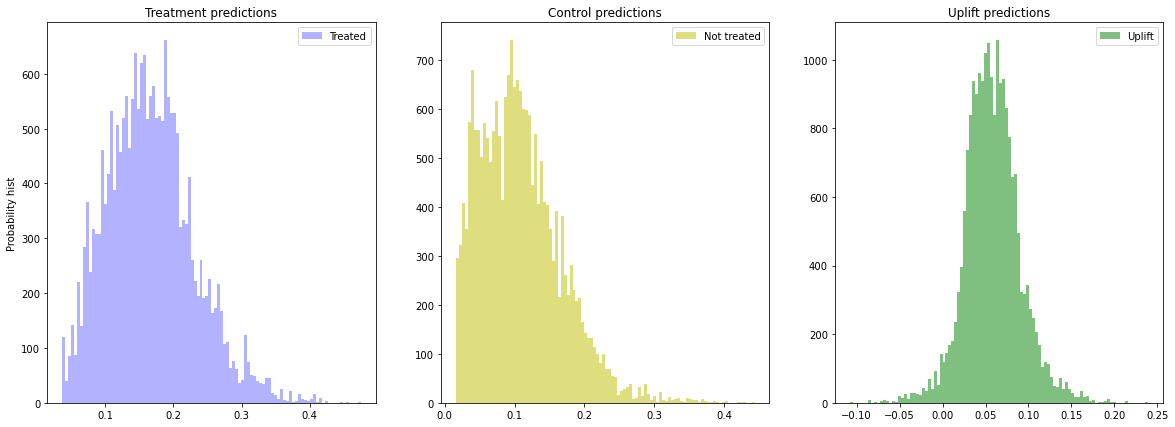

In [29]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')

sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_20:.4f}')


sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score_30:.4f}')

models_results.loc[len(models_results)] = ['SoloModel', sm_score_10, sm_score_20, sm_score_30]

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

## Модель с трансформацией таргета

In [30]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)

ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results.loc[len(models_results)] = ['ClassTransformation', ct_score_10, ct_score_20, ct_score_30]


C:\Users\Admin\AppData\Local\Temp/ipykernel_18048/2956483622.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [32]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,17.901431
1,recency,16.270941
2,treatment,15.743538
3,history,13.050824
4,used_bogo,10.343734
5,Rural,7.745292
6,used_discount,7.363371
7,Web,5.777285
8,Phone,2.195605
9,Urban,1.672482


In [33]:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,recency,22.085007
1,history,21.577953
2,is_referral,15.938978
3,used_bogo,9.509358
4,Urban,5.965262
5,Phone,5.317345
6,Surburban,4.833009
7,used_discount,4.578984
8,Multichannel,3.988509
9,Rural,3.407751


## Две модели

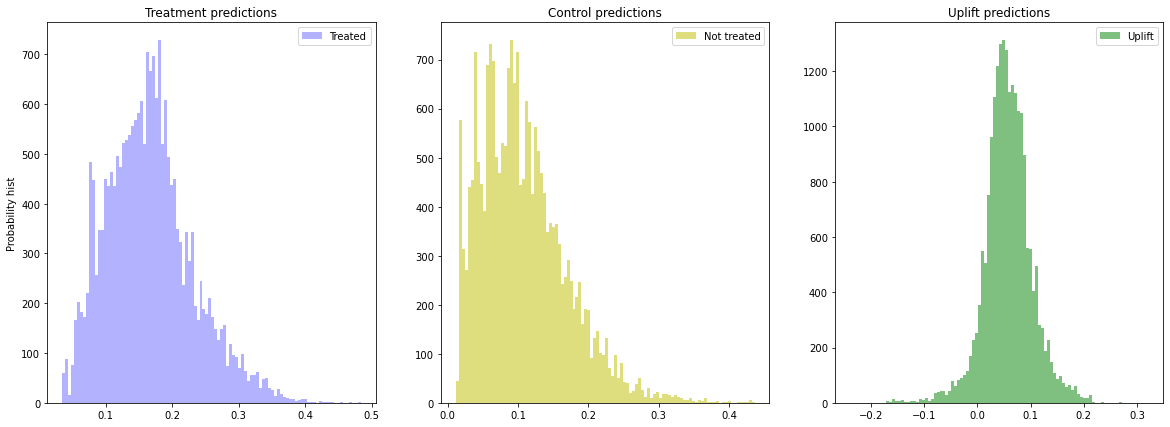

In [36]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)

tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results.loc[len(models_results)] = ['TwoModels', tm_score_10, tm_score_20, tm_score_30]

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

## Итоговый скор

In [38]:
models_results

,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.100938,0.091870,0.085123
1,ClassTransformation,0.083394,0.081396,0.085069
2,TwoModels,0.103024,0.087607,0.077123


## Дерево

In [39]:
cat_features

['is_referral']

In [40]:
X_train_tree = pd.concat([X_train.drop('is_referral', axis=1), 
                          pd.get_dummies(X_train['is_referral'], prefix='is_referral')], 1)
features = [col for col in X_train_tree]

C:\Users\Admin\AppData\Local\Temp/ipykernel_18048/4136732121.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  X_train_tree = pd.concat([X_train.drop('is_referral', axis=1),


In [43]:
%%time
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)


Wall time: 3.57 s


In [44]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

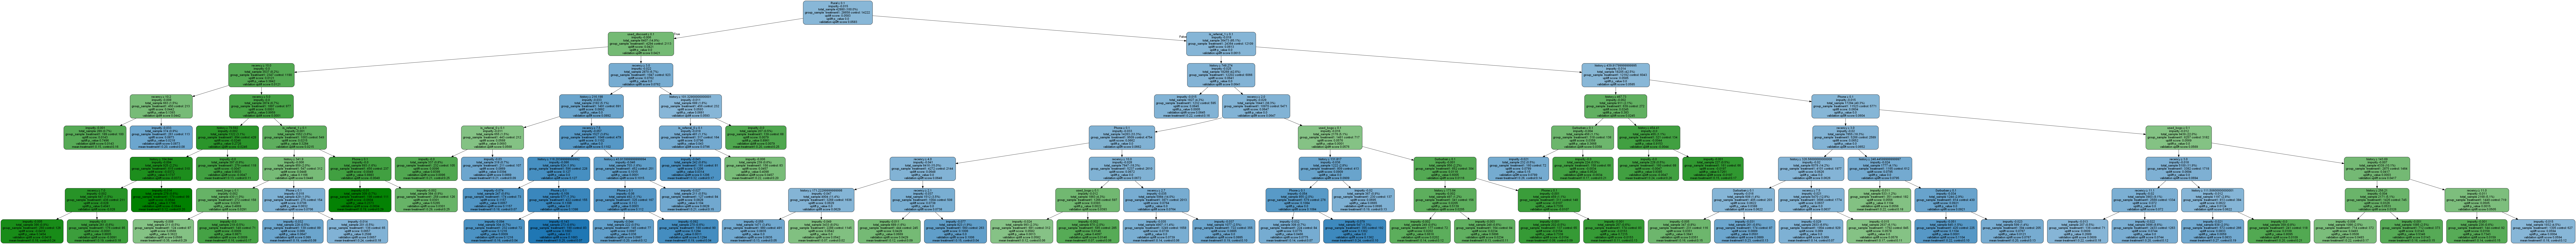

In [45]:
Image(graph.create_png())

для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 
1. сделать прогноз и получить uplift для тестовой выборки 
2. отсортировать тестовую выборку по uplift по убыванию 
3. разбить на децили (pandas qcut вам в помощь) 
4. для каждого дециля посчитать среднюю conversion